In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np 
import camb 
import healpy as hp

import lensit as li
from lensit.clusterlens import lensingmap, profile 
from lensit.misc.misc_utils import gauss_beam
from lensit.ffs_covs import ffs_cov, ell_mat

import os
import os.path as op
import matplotlib as mpl
from matplotlib import pyplot as plt

from scipy.interpolate import UnivariateSpline as spline
from plancklens.wigners import wigners

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['font.size'] = 20
mpl.rcParams['figure.figsize'] = 8.5, 5.5

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rc('text', usetex=True)
mpl.rcParams['errorbar.capsize'] = 4
mpl.rc('legend', fontsize=15)

In [2]:
def cli(cl):
    ret = np.zeros_like(cl)
    ret[np.where(cl > 0)] = 1. / cl[np.where(cl > 0)]
    return ret

def pp_to_kk(ls):
    return ls ** 2 * (ls+1.) ** 2 * 0.25 

def kk_to_pp(ls):
    return cli(pp_to_kk(ls))

In [3]:
# We start by intiating CAMB which will give us the relevant cosmology 
cambinifile = 'planck_2018_acc'

pars = camb.read_ini(op.join(op.dirname('/Users/sayan/CMB_WORK/CAMB-1.1.3/inifiles'),  'inifiles', cambinifile + '.ini'))
results = camb.get_results(pars)

In [4]:
# We define here the parameters for the profile of the cluster
M200, z = 2 * 1e14, 0.7
profname = 'nfw'
profparams={'M200c':M200, 'z':z}

# Define here the map square patches
npix = 1024  # Number of pixels
lpix_amin = 0.3 # Physical size of a pixel in arcmin (There is bug when <0.2 amin, due to low precision in Cl_TE at )

# Maximum multipole used to generate the CMB maps from the CMB power spectra
# ellmaxsky = 6000 # (bug when ellmax>6300 because of low precision in Cl_TE of CAMB )
ellmaxsky = 8000 

# Set the maximum ell observed in the CMB data maps
ellmaxdat = 3000


# Number of simulated maps 
nsims = 100

# Set CMB experiment for noise level and beam
cmb_exp='S4_sayan'

# We will cache things in this directory 
libdir = lensingmap.get_cluster_libdir(cambinifile, profname, npix, lpix_amin, ellmaxsky, M200, z, nsims, cmb_exp)
print(libdir)

/Users/sayan/Project_Geneva/Carron_codes/LensIt-master-3/lensit/temp/clustermaps/camb_planck_2018_acc/cmbexp_S4_sayan/nfw_profile/npix1024_lpix_0.3amin_lmaxsky8000/M200_2.000000E+14_z0.7/100_sims


In [5]:
lmax = ellmaxsky
cpp_fid = results.get_lens_potential_cls(lmax=lmax, raw_cl=True).T[0]

camb_cls = results.get_unlensed_scalar_cls(CMB_unit='muK', raw_cl=True, lmax=lmax).T
cls_unl_fid = {'tt':camb_cls[0], 'ee':camb_cls[1], 'bb':camb_cls[2], 'te':camb_cls[3], 'pp':cpp_fid}

camb_cls_len = results.get_lensed_scalar_cls(CMB_unit='muK', raw_cl=True, lmax=lmax).T
cls_len_fid = {'tt':camb_cls_len[0], 'ee':camb_cls_len[1], 'bb':camb_cls_len[2], 'te':camb_cls_len[3], 'pp':cpp_fid}

In [6]:
clustermaps = lensingmap.cluster_maps(libdir, npix, lpix_amin, nsims, results, profparams, profilename=profname,  ellmax_sky = ellmaxsky, ellmax_data=ellmaxdat, cmb_exp=cmb_exp)

/Users/sayan/Project_Geneva/git_repos/LensIt/lensit/clusterlens/profile.py:279: RuntimeWarning: invalid value encountered in true_divide
  dx_lm = 2 * rfft_kappa * 1.j * KX / (KX**2+KY**2)
/Users/sayan/Project_Geneva/git_repos/LensIt/lensit/clusterlens/profile.py:280: RuntimeWarning: invalid value encountered in true_divide
  dy_lm = 2 * rfft_kappa * 1.j * KY / (KX**2+KY**2)


In [9]:
ellmax_sky = clustermaps.ellmax_sky
sN_uKamin, sN_uKaminP, Beam_FWHM_amin, ellmin, ellmax = li.get_config(clustermaps.cmb_exp)
transf = hp.gauss_beam(1. / 180 / 60 * np.pi, lmax=ellmax_sky)
cls_noise = {'t': (sN_uKamin * np.pi / 180. / 60.) ** 2 * np.ones(clustermaps.ellmax_sky + 1),
            'q':(sN_uKaminP * np.pi / 180. / 60.) ** 2 * np.ones(clustermaps.ellmax_sky + 1),
            'u':(sN_uKaminP * np.pi / 180. / 60.) ** 2 * np.ones(clustermaps.ellmax_sky + 1)}  # simple flat noise Cls
# cl_transf = gauss_beam(Beam_FWHM_amin / 60. * np.pi / 180., lmax=ellmax_sky)
# lib_alm = ell_mat.ffs_alm_pyFFTW(get_ellmat(LD_res, HD_res=HD_res),
                    # filt_func=lambda ell: (ell >= ellmin) & (ell <= ellmax), num_threads=pyFFTWthreads)
# lib_skyalm = ell_mat.ffs_alm_pyFFTW(clustermaps.ellmat,
                    # filt_func=lambda ell: (ell <= ellmax_sky), num_threads=clustermaps.num_threads)

cl_transf = clustermaps.cl_transf
lib_skyalm = clustermaps.lib_skyalm


typ = 'T'

lib_dir = op.join(clustermaps.dat_libdir, typ)
# isocov = ffs_cov.ffs_diagcov_alm(lib_dir, clustermaps.lib_datalm, clustermaps.cls_unl, cls_len, cl_transf, cls_noise, lib_skyalm=lib_skyalm)
isocov = ffs_cov.ffs_diagcov_alm(lib_dir, clustermaps.lib_datalm, clustermaps.cls_unl, clustermaps.cls_unl, cl_transf, cls_noise, lib_skyalm=lib_skyalm)

In [10]:
ell, = np.where(lib_skyalm.get_Nell()[:ellmaxsky+1])
kappa_map = clustermaps.get_kappa_map(clustermaps.M200, clustermaps.z)

hprofile = profile.profile(results, profname)
xmax = hprofile.get_concentration(M200, z) # truncating at virial radius seems like at reasonable thing
lmax = ellmaxsky
R_200 = hprofile.get_r200(M200, z)
R_s = hprofile.get_rs(M200,z)
thtscale = hprofile.r_to_theta(z, R_s)
thtmax = hprofile.r_to_theta(z, R_200)
#thtmax = hprofile.x_to_theta_amin(M200, z, xmax)
#thtscale = hprofile.x_to_theta_amin(M200, z, 1.)

print('thmax in amin, thscale', thtmax, thtscale)
xg, wg = wigners.get_xgwg(np.cos(thtmax / 180 / 60 * np.pi),1., max(5000, int(lmax * thtmax / (360 * 60))))
kappa = hprofile.kappa_theta(M200, 1., np.arccos(xg) / np.pi * 180 * 60 )
kappa_ell = wigners.wignercoeff(kappa * wg, xg, 0, 0, lmax)
ckk_map = kappa_ell **2 / 4 / np.pi

thmax in amin, thscale 2.139100514187885 0.6846534736764758


In [88]:
def get_starting_point(idx, typ, clustermaps): 
    """
    This returns initial data for simulation index 'idx' from a CMB-S4 simulation library.
    On first call the simulation library will generate all simulations phases, hence might take a little while.
    """ 

    print(" I will be using data from ell=%s to ell=%s only"%(isocov.lib_datalm.ellmin, isocov.lib_datalm.ellmax))
    print(" The sky band-limit is ell=%s"%(isocov.lib_skyalm.ellmax))
    # isocov.lib_datalm defines the mode-filtering applied on the data, 
    # and isocov.lib_skyalm the band-limits of the unlensed sky.
    lib_qlm = isocov.lib_skyalm #: This means we will reconstruct the lensing potential for all unlensed sky modes.
    # lib_qlm = isocov.lib_datalm #: This means we will reconstruct the lensing potential for data modes.

    # We now build the Wiener-filtered quadratic estimator. We use lensed CMB spectra in the weights.
    if typ=='QU':
        datalms = np.array([isocov.lib_datalm.map2alm(m) for m in clustermaps.maps_lib.get_sim_qumap(idx)]) 
    elif typ =='T':
        datalms = np.array([isocov.lib_datalm.map2alm(clustermaps.maps_lib.get_sim_tmap(idx))]) 
    
    use_cls_len = True
    
    H0len =  cli(isocov.get_N0cls(typ, lib_qlm, use_cls_len=use_cls_len)[0])
    plm = 0.5 * isocov.get_qlms(typ,  isocov.get_iblms(typ, datalms, use_cls_len=use_cls_len)[0], lib_qlm, 
                                 use_cls_len=use_cls_len)[0]
    
    # Normalization and Wiener-filtering:
    # cpp_prior = li.get_fidcls()[0]['pp'][:lib_qlm.ellmax+1]

    plmqe  = lib_qlm.almxfl(plm, cli(H0len), inplace=False)
    return plmqe, H0len

idx = 0
plmqe, H0len= get_starting_point(idx, typ, clustermaps)

 I will be using data from ell=70 to ell=2997 only
 The sky band-limit is ell=8000
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  


In [27]:
from plancklens import n0s
#nlevt = 1
nlev_t, nlev_p, beam_fwhm_amin, lmin_cmb, lmax_cmb = li.get_config(cmb_exp)
cpp_fid = results.get_lens_potential_cls(lmax=lmax, raw_cl=True).T[0]
camb_cls = results.get_unlensed_scalar_cls(CMB_unit='muK', raw_cl=True, lmax=lmax).T
cls_unl_fid = {'tt':camb_cls[0], 'ee':camb_cls[1], 'bb':camb_cls[2], 'te':camb_cls[3], 'pp':cpp_fid}

camb_cls_len = results.get_lensed_scalar_cls(CMB_unit='muK', raw_cl=True, lmax=lmax).T
cls_len_fid = {'tt':camb_cls_len[0], 'ee':camb_cls_len[1], 'bb':camb_cls_len[2], 'te':camb_cls_len[3], 'pp':cpp_fid}

N0s, N0s_curl = n0s.get_N0(beam_fwhm=1, nlev_t=nlev_t, nlev_p=nlev_t*np.sqrt(2), lmax_CMB=lmax_cmb, lmin_CMB=lmin_cmb, lmax_out=3000, cls_len=cls_len_fid, cls_weight=cls_len_fid)
Nl = N0s['ptt']

Text(0.5, 1.0, 'lmax=3000, lmin=1')

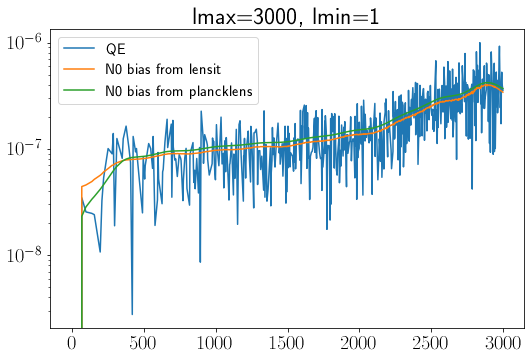

In [89]:
ell, = np.where(isocov.lib_skyalm.get_Nell()[:3000])
#ell = ell[100:]
nlev_t, nlev_p, beam_fwhm_amin, lmin_cmb, lmax_cmb = li.get_config(cmb_exp)
kappa_map =clustermaps.get_kappa_map(clustermaps.M200, clustermaps.z)

plt.semilogy(ell, lib_qlm.alm2cl(plmqe)[ell]  * pp_to_kk(ell), label='QE')
#plt.plot(ell, ckk_map[ell], label='Cl(input kappa)')
#plt.loglog()
plt.plot(ell, cli(H0len)[ell]*pp_to_kk(ell), label='N0 bias from lensit')
plt.plot(ell, Nl[ell]*pp_to_kk(ell), label='N0 bias from plancklens')
plt.legend()
plt.title("lmax=%i, lmin=%i"%(lmax_cmb,lmin_cmb))
#plt.savefig("Nl_compare_lmax%i_lmin%i.pdf"%(lmax_cmb,lmin_cmb))

## $\kappa_0$ Estimate

\begin{align}
    \hat{\kappa_0} = \frac{\sum_L  \kappa^t_{L0} \hat \kappa_{L0} N^{-1}_L}{\sum_L  \kappa^t_{L0} \kappa^{t\ast}_{L0} N^{-1}_L}
\end{align}

\begin{align}
    \kappa^t_{LM} = \delta_{M 0} \sqrt {\frac{2 L + 1}{4\pi}} 2\pi \int_{-1}^{+1} d\cos \theta\: \kappa^t(\theta) P_L(\cos\theta) \equiv  \delta_{M 0} \sqrt {\frac{2 L + 1}{4\pi}} \kappa^t_L.
\end{align}

In [94]:
typ = 'T'
lib_qlm = isocov.lib_skyalm
use_cls_len = True
NL = isocov.get_N0cls(typ, lib_qlm, use_cls_len=use_cls_len)[0]
kappa0 = hprofile.get_kappa0(M200,z)

def kappa_0_est(lmin, lmax, phi_obs_lm, NL):
    ell, = np.where(clustermaps.lib_skyalm.get_Nell()[:lmax+1] > 1)
    for i in range(len(ell)):
        if ell[i] >= lmin:
            m = i
            exit
    ell = ell[m:]
    phi_obs_el = clustermaps.lib_skyalm.bin_realpart_inell(phi_obs_lm)
    denom_int = (2*ell + 1)*(kappa_ell[ell]/kappa0)**2/(4 * np.pi)/(NL[ell]*pp_to_kk(ell))
    denom = np.sum(denom_int)
    num_int = np.sqrt((2*ell + 1)/ 4 / np.pi)*(kappa_ell[ell]/kappa0)*phi_obs_el[ell]*(ell+1)*ell /2 /(NL[ell]*pp_to_kk(ell))
    numer = np.sum(num_int)
    return numer/denom

In [95]:
idx = 1
plmqe, H0len = get_starting_point(idx, typ, clustermaps)
kappa_0_sim = kappa_0_est(lmin=100, lmax=3000, phi_obs_lm=plmqe, NL=cli(H0len))
kappa_0_sim

 I will be using data from ell=70 to ell=2997 only
 The sky band-limit is ell=8000
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  


13.217281081471896

In [92]:
nmaps = 100
lmax, lmin= 3000,1
plmqes = [None]*nmaps
H0lens = [None]*nmaps
kappa_0_sims = [None]*nmaps
if nsims >1:
    for idx in range(nmaps):
        print(idx)
        plmqes[idx], H0lens[idx] = get_starting_point(idx, typ, clustermaps)
        kappa_0_sims[idx] = kappa_0_est(lmin=lmin, lmax=lmax, phi_obs_lm=plmqes[idx], NL=Nl)

0
 I will be using data from ell=70 to ell=2997 only
 The sky band-limit is ell=8000
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  
1
 I will be using data from ell=70 to ell=2997 only
 The sky band-limit is ell=8000
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  
2
 I will be using data from ell=70 to ell=2997 only
 The sky band-limit is ell=8000
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  
3
 I will be using data from ell=70 to ell=2997 only
 The sky band-limit is ell=8000
     [00:00:00]  (total [00

The error and the mean for $\kappa_0$ value of $10^5$ number of clusters

In [100]:
n_extra = 1e5/nmaps
inv_snr = np.std(kappa_0_sims)/np.mean(kappa_0_sims)
inv_snr

150.47895493635926

In [102]:
N0s, N0s_curl = n0s.get_N0(beam_fwhm= 1.,nlev_t= 1.,nlev_p=1*np.sqrt(2.), lmin_CMB=70, lmax_CMB=3000, lmax_out=4000, cls_len=cls_len_fid, cls_weight=cls_len_fid)
NL = {}
NL['ptt'] = N0s['ptt'] #+ cpp_fid
NL['p_p'] = N0s['p_p'] #+ cpp_fid
NL['p'] = N0s['p'] #+ cpp_fid

N_clusters = 100
ell = np.arange(100,3000+1)
kappa0 = hprofile.get_kappa0(M200, z)
kappa_l = kappa_ell[ell]    
snr_tt = (2*ell + 1)*(kappa_l/kappa0)**2/(NL["ptt"][ell]*pp_to_kk(ell))/(4 * np.pi)
sigma_kappa0_tt = np.sqrt(1./np.sum(snr_tt))
sigma_kappa0_tt / kappa0 / np.sqrt(N_clusters)

0.6252706474368079

In [103]:
np.mean(kappa_0_sims),kappa0

(0.12109145537603334, 0.1304376641635279)